## Feature Scaling & Modeling

### Importing Required Packages

In [39]:
### Basic importing 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Modeling packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import warnings


#### Import the data 

In [40]:
data = pd.read_csv('data/indian_liver_patient.csv')
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [41]:
unscaled_data= data.copy()
unscaled_data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


### Feature Scaling

#### 1. Feature Scaling with log1p

In [42]:
## list of skewed columns 
skewed_col = ['Total_Bilirubin',
              'Direct_Bilirubin',
              'Alkaline_Phosphotase',
              'Alamine_Aminotransferase',
              'Aspartate_Aminotransferase']

### apply log1p
for col in skewed_col:
    data[col] = np.log1p(data[col]) 

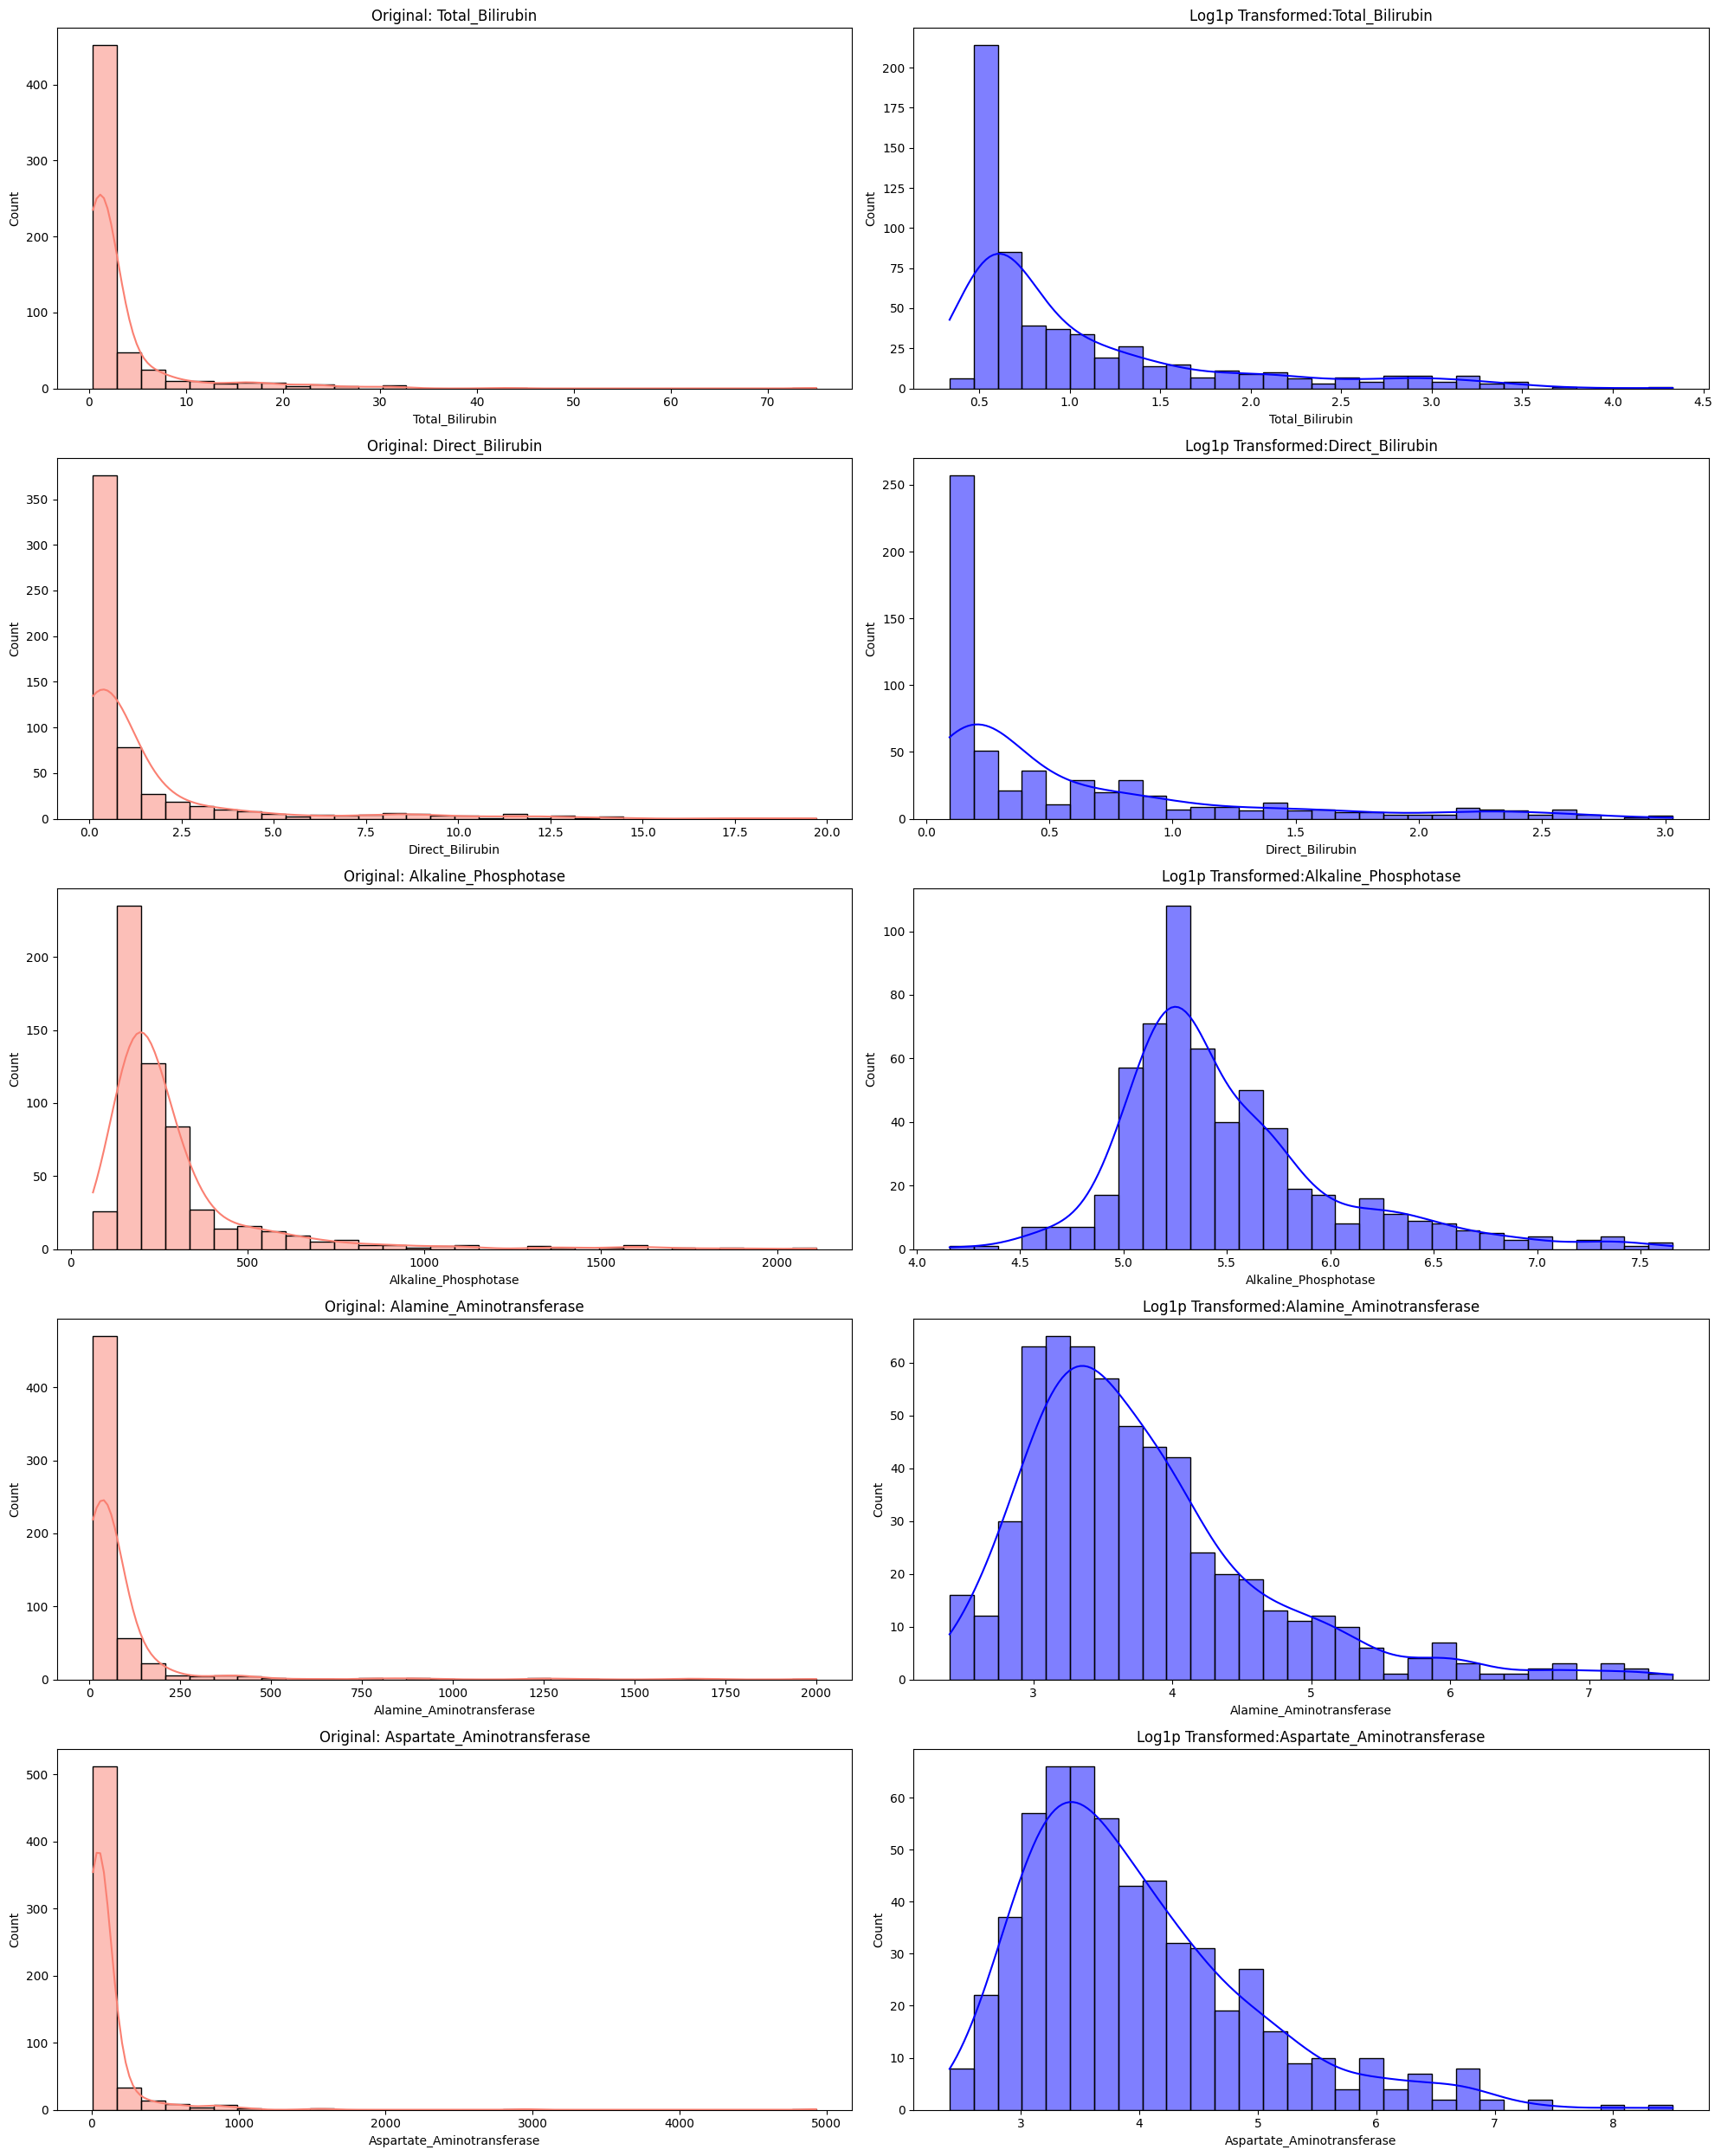

In [43]:
plt.figure(figsize=(20,25))

for i, feature in enumerate(skewed_col):
    # original feature plot
    plt.subplot(len(skewed_col), 2, 2*i+1)
    sns.histplot(unscaled_data[feature], kde=True, bins=30, color='salmon')
    plt.title(f'Original: {feature}')

    # log transformed feature plot
    plt.subplot(len(skewed_col), 2, 2*i+2)
    sns.histplot(data[feature], kde= True, bins=30, color='blue')
    plt.title(f'Log1p Transformed:{feature}')

plt.tight_layout()
plt.show()

### Insights

* Alkaline_Phosphatase, Alamine_Aminotransferase, Aspartate_Aminotransferase show good improvement. Now they are closer to normal distribution, even if still a bit right-skewed.
* Total_Bilirubin, Direct_Bilirubin are still heavily right skewed even after `log1p` trandformation.

In [44]:
### powertransformer for total and direct bilirubin

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
data[['Total_Bilirubin','Direct_Bilirubin']] = pt.fit_transform(data[['Total_Bilirubin', 'Direct_Bilirubin']])


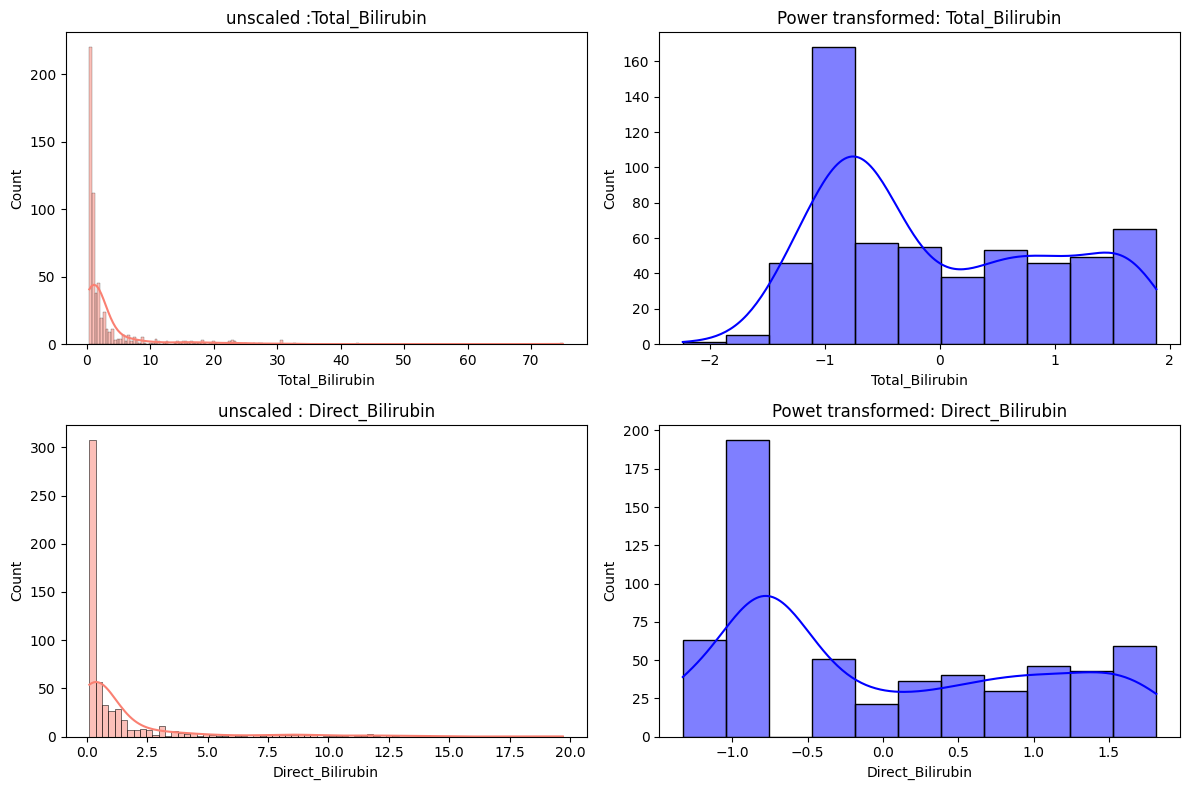

In [45]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

# original Total_Bilirubin
sns.histplot(unscaled_data['Total_Bilirubin'], kde= True, ax=axes[0,0], color='salmon')
axes[0,0].set_title('unscaled :Total_Bilirubin')

# transformed Total_Bilirubin
sns.histplot(data['Total_Bilirubin'], kde=True, ax=axes[0,1], color='blue')
axes[0,1].set_title('Power transformed: Total_Bilirubin')

# original Direct_Bilirubin
sns.histplot(unscaled_data['Direct_Bilirubin'], kde=True, ax=axes[1,0], color='salmon')
axes[1,0].set_title('unscaled : Direct_Bilirubin')

# transformed Direct_Bilirubin
sns.histplot(data['Direct_Bilirubin'],kde=True,ax=axes[1,1], color='blue')
axes[1,1].set_title('Powet transformed: Direct_Bilirubin')

plt.tight_layout()
plt.show()

In [46]:
### apply powertransformer to the remaining skewed features
data[['Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase']] = pt.fit_transform(data[['Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase']])
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,-1.004215,-1.328118,-0.422506,-1.419124,-1.333401,6.8,3.3,0.90,1
1,62,Male,1.632316,1.616631,1.766398,0.696849,0.849595,7.5,3.2,0.74,1
2,62,Male,1.510992,1.534661,1.353793,0.630464,0.504947,7.0,3.3,0.89,1
3,58,Male,-0.326685,-0.119766,-0.492515,-1.731577,-1.136108,6.8,3.4,1.00,1
4,72,Male,1.211469,1.232441,-0.317060,-0.416270,0.361851,7.3,2.4,0.40,1


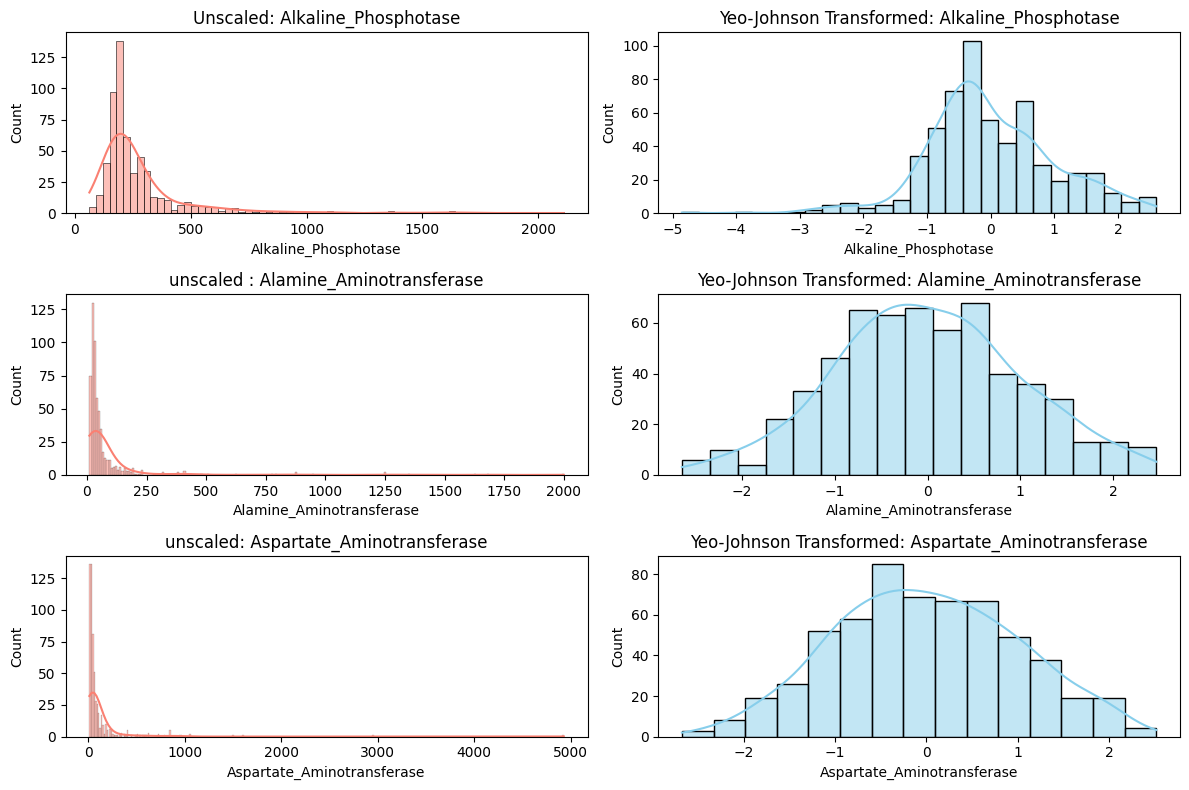

In [47]:
### ploting power transformed features 

fig, axes = plt.subplots(3,2, figsize= (12,8))

# original Alkaline_Phosphotase
sns.histplot(unscaled_data['Alkaline_Phosphotase'], kde=True, ax=axes[0, 0], color='salmon')
axes[0, 0].set_title('Unscaled: Alkaline_Phosphotase')

# Transformed Alkaline_Phosphotase
sns.histplot(data['Alkaline_Phosphotase'], kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Yeo-Johnson Transformed: Alkaline_Phosphotase')

# Original Alamine_Aminotransferase
sns.histplot(unscaled_data['Alamine_Aminotransferase'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('unscaled : Alamine_Aminotransferase')

# Transformed Alamine_Aminotransferase
sns.histplot(data['Alamine_Aminotransferase'], kde=True, ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Yeo-Johnson Transformed: Alamine_Aminotransferase')

# Original Aspartate_Aminotransferase
sns.histplot(unscaled_data['Aspartate_Aminotransferase'], kde=True, ax=axes[2, 0], color='salmon')
axes[2, 0].set_title('unscaled: Aspartate_Aminotransferase')

# Transformed Aspartate_Aminotransferase
sns.histplot(data['Aspartate_Aminotransferase'], kde=True, ax=axes[2, 1], color='skyblue')
axes[2, 1].set_title('Yeo-Johnson Transformed: Aspartate_Aminotransferase')

plt.tight_layout()
plt.show()

* Finally they are much closer to the normal distribution.

In [48]:
data.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [49]:
data.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,5.830000e+02,5.830000e+02,5.830000e+02,5.830000e+02,5.830000e+02,583.000000,583.000000,579.000000,583.000000
mean,44.746141,-2.285193e-16,-2.498478e-16,6.840954e-14,-8.994520e-15,3.089581e-15,6.483190,3.141852,0.947064,1.286449
std,16.189833,1.000859e+00,1.000859e+00,1.000859e+00,1.000859e+00,1.000859e+00,1.085451,0.795519,0.319592,0.452490
min,4.000000,-2.233658e+00,-1.328118e+00,-4.853504e+00,-2.648972e+00,-2.680545e+00,2.700000,0.900000,0.300000,1.000000
25%,33.000000,-7.379350e-01,-7.982106e-01,-5.887587e-01,-6.904782e-01,-7.541936e-01,5.800000,2.600000,0.700000,1.000000
50%,45.000000,-3.266855e-01,-4.120991e-01,-1.609254e-01,-2.359871e-02,-2.311403e-02,6.600000,3.100000,0.930000,1.000000
75%,58.000000,9.093089e-01,9.605006e-01,5.862323e-01,6.390716e-01,7.320069e-01,7.200000,3.800000,1.100000,2.000000
max,90.000000,1.884426e+00,1.814562e+00,2.602449e+00,2.465269e+00,2.519385e+00,9.600000,5.500000,2.800000,2.000000


In [50]:
data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [51]:
unscaled_data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [52]:
data['Albumin_and_Globulin_Ratio'] = data['Albumin_and_Globulin_Ratio'].fillna(data['Albumin_and_Globulin_Ratio'].median())

In [53]:
unscaled_data['Albumin_and_Globulin_Ratio'] = unscaled_data['Albumin_and_Globulin_Ratio'].fillna(unscaled_data['Albumin_and_Globulin_Ratio'].median())

In [54]:
data.duplicated().sum()

np.int64(13)

In [55]:
data = data.drop_duplicates()

In [56]:
unscaled_data.duplicated().sum()

np.int64(13)

In [57]:
unscaled_data = unscaled_data.drop_duplicates()

#### Preparing X and Y

In [58]:
# Creating X for unscaled and scaled data
X_scaled = data.drop(columns=['Dataset'], axis= 1)
X_unscaled = unscaled_data.drop(columns=['Dataset'], axis=1)
X_scaled.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,65,Female,-1.004215,-1.328118,-0.422506,-1.419124,-1.333401,6.8,3.3,0.90
1,62,Male,1.632316,1.616631,1.766398,0.696849,0.849595,7.5,3.2,0.74
2,62,Male,1.510992,1.534661,1.353793,0.630464,0.504947,7.0,3.3,0.89
3,58,Male,-0.326685,-0.119766,-0.492515,-1.731577,-1.136108,6.8,3.4,1.00
4,72,Male,1.211469,1.232441,-0.317060,-0.416270,0.361851,7.3,2.4,0.40


In [59]:
X_unscaled.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40


In [60]:
# Creating y for scaled and unscaled data
y_scaled = data['Dataset']
y_unscaled = unscaled_data['Dataset']

In [61]:
# Transforme Categorical features into numerical features

cat_col_orig = X_unscaled.select_dtypes(include='object').columns
num_col_orig = X_unscaled.select_dtypes(exclude='object').columns

cat_col_scaled = X_scaled.select_dtypes(include='object').columns

In [62]:
## Preprocessing Pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# for unscaled data need both encoding and scaling 
preprocessor_unscaled = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_col_orig),
        ('cat', OneHotEncoder(), cat_col_orig)
    ]
)

# for already scaled data only need encoding
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_col_scaled)
    ],
    remainder= 'passthrough'
)

# Transform separately
X_unscaled_processed = preprocessor_unscaled.fit_transform(X_unscaled)
X_scaled_processed = preprocessor_scaled.fit_transform(X_scaled)

In [63]:
# create train and test split from X_unscaled and y_unscaled
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled_processed, y_unscaled, test_size= 0.2, random_state= 42)
X_train_unscaled.shape, X_test_unscaled.shape

((456, 11), (114, 11))

In [64]:
# create train and test split from X_scaled and y_scaled
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled_processed, y_scaled, test_size=0.2, random_state=42)
X_train_scaled.shape, X_test_scaled.shape

((456, 11), (114, 11))

In [65]:
y_train_scaled.value_counts()

Dataset
1    321
2    135
Name: count, dtype: int64

In [66]:
y_train_unscaled.value_counts()

Dataset
1    321
2    135
Name: count, dtype: int64

#### Label Encoding

In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# label encoding for scaled y_train and y_test 
y_train_scaled = le.fit_transform(y_train_scaled)
y_test_scaled = le.fit_transform(y_test_scaled)

# label encoding for unscaled y_train and y_test
y_train_unscaled = le.fit_transform(y_train_unscaled)
y_test_unscaled = le.fit_transform(y_test_unscaled)

y_train_scaled.shape

(456,)

In [68]:
unscaled_models = {
    "Random Forest" : RandomForestClassifier(random_state=42),
    "XG Boost" : XGBClassifier(random_state = 42),
    "Cat Boost" : CatBoostClassifier(random_state=42)
}
scaled_models = {
    "logistic regression" : LogisticRegression(max_iter=500, random_state=42),
    "KNN" : KNeighborsClassifier()
}

### Handling Imbalance


#### Handling Imbalance data Using SMOTE

In [69]:
### Handle imbalance in scaled data using smote
smote = SMOTE(random_state=42)
X_train_scaled_bal, y_train_scaled_bal = smote.fit_resample(X_train_scaled, y_train_scaled)

### Handle imbalance in unscaled data using smote
X_train_unscaled_bal, y_train_unscaled_bal = smote.fit_resample(X_train_unscaled, y_train_unscaled)

print("===== Scaled Models ====")
for name, model in scaled_models.items():
    model.fit(X_train_scaled_bal, y_train_scaled_bal)
    y_pred = model.predict(X_test_scaled)
    print(f'{name}:')
    print(classification_report(y_test_scaled, y_pred))

print("==== Unscaled Models =====")
for name, model in unscaled_models.items():
    model.fit(X_train_unscaled_bal, y_train_unscaled_bal)
    y_pred = model.predict(X_test_unscaled)
    print(f'{name}:')
    print(classification_report(y_test_unscaled, y_pred))



===== Scaled Models ====
logistic regression:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        85
           1       0.37      0.72      0.49        29

    accuracy                           0.61       114
   macro avg       0.61      0.65      0.59       114
weighted avg       0.73      0.61      0.64       114

KNN:
              precision    recall  f1-score   support

           0       0.85      0.54      0.66        85
           1       0.35      0.72      0.47        29

    accuracy                           0.59       114
   macro avg       0.60      0.63      0.57       114
weighted avg       0.72      0.59      0.61       114

==== Unscaled Models =====
Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        85
           1       0.40      0.59      0.48        29

    accuracy                           0.68       114
   macro avg       0.62      0.65  

#### SMOTE Result

| Model             | F1 Score (Macro Avg) | Accuracy |
| -------------     | -------------------- | -------- |
| Random Forest     | 0.62                 | 0.68     |
| logistic regre    | 0.59                 | 0.61     |
| svm               | 0.61                 | 0.63     |
| knn               | 0.62                 | 0.69     |
| XGboost           | 0.60                 | 0.69     |
| Decision Tree     | 0 56                 | 0.63     |
| Catboost          | 0.62                 | 0.69     |

#### SMOTETomek Result 

| Model             | F1 Score (Macro Avg) | Accuracy |
| -------------     | -------------------- | -------- |
| Random Forest     | 0.64                 | 0.71     |
| logistic regre    | 0.60                 | 0.62     |
| svm               | 0.62                 | 0.64     |
| knn               | 0.55                 | 0.57     |
| XGboost           | 0.60                 | 0.69     |
| Decision Tree     | 0 57                 | 0.63     |
| Catboost          | 0.62                 | 0.68     |

#### ADASYN Result

| Model             | F1 Score (Macro Avg) | Accuracy |
| -------------     | -------------------- | -------- |
| Random Forest     | 0.61                 | 0.68     |
| logistic regre    | 0.61                 | 0.64     |
| svm               | 0.65                 | 0.70     |
| knn               | 0.53                 | 0.55     |
| XGboost           | 0.55                 | 0.65     |
| Decision Tree     | 0 58                 | 0.62     |
| Catboost          | 0.65                 | 0.71     |

* Even after tried different imbalance techniques i don't get better f1 score.
so i choose `smote` technique for the final models. 

#### Models with `class_weight = balanced`

In [70]:
unscaled_models = {
    "Random Forest" : RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XG Boost" : XGBClassifier(scale_pos_weight = 321/135, random_state = 42),
    "Cat Boost" : CatBoostClassifier(random_state=42, class_weights = [1,3])
}
scaled_models = {
    "logistic regression" : LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    "KNN" : KNeighborsClassifier()
}

In [71]:
from sklearn.model_selection import cross_validate

model_list = []
avg_f1_score = []
avg_accuracy = []

# Scaled models
for name, model in scaled_models.items():
    scores = cross_validate(model, X_train_scaled_bal, y_train_scaled_bal, cv = 5, scoring= {'f1':'f1_macro', 'acc':'accuracy'})
    print("model:", name)
    model_list.append(name)
    print("F1 score:",scores['test_f1'])
    print("mean of F1 score:", scores['test_f1'].mean())
    avg_f1_score.append(scores['test_f1'].mean())
    print("Accuracy scores:", scores['test_acc'])
    print("Mean Accuracy:", scores['test_acc'].mean())
    avg_accuracy.append(scores['test_acc'].mean())
    print('-'*40)

# for unscaled models 
for name, model in unscaled_models.items():
    scores = cross_validate(model, X_train_unscaled_bal, y_train_unscaled_bal, cv = 5, scoring= {'f1':'f1_macro', 'acc':'accuracy'})
    print("model:", name)
    model_list.append(name)
    print("F1 score:",scores['test_f1'])
    print("mean of F1 score:", scores['test_f1'].mean())
    avg_f1_score.append(scores['test_f1'].mean())
    print("Accuracy scores:", scores['test_acc'])
    print("Mean Accuracy:", scores['test_acc'].mean())
    avg_accuracy.append(scores['test_acc'].mean())
    print('-'*40)

print(avg_accuracy)
print(avg_f1_score)
print(model_list)

model: logistic regression
F1 score: [0.68674114 0.76731602 0.73115888 0.68984157 0.69213691]
mean of F1 score: 0.713438902577048
Accuracy scores: [0.68992248 0.76744186 0.734375   0.6953125  0.6953125 ]
Mean Accuracy: 0.7164728682170542
----------------------------------------
model: KNN
F1 score: [0.75759229 0.83526908 0.71382945 0.81534216 0.75975976]
mean of F1 score: 0.7763585463814896
Accuracy scores: [0.75968992 0.8372093  0.7265625  0.8203125  0.765625  ]
Mean Accuracy: 0.7818798449612403
----------------------------------------
model: Random Forest
F1 score: [0.75180375 0.72861694 0.79507389 0.85653798 0.77777778]
mean of F1 score: 0.7819620683844863
Accuracy scores: [0.75193798 0.72868217 0.796875   0.859375   0.78125   ]
Mean Accuracy: 0.7836240310077519
----------------------------------------
model: XG Boost
F1 score: [0.72868217 0.72763467 0.85001542 0.81431725 0.80871731]
mean of F1 score: 0.7858733646161451
Accuracy scores: [0.72868217 0.72868217 0.8515625  0.8203125  0

In [72]:
# Make the Output into DataFrame
pd.DataFrame(list(zip(model_list, avg_f1_score, avg_accuracy)),columns=['Model Name','Avg F1 Score', 'Avg Accuracy']).sort_values(by=['Avg Accuracy'],ascending=False)

,Model Name,Avg F1 Score,Avg Accuracy
3,XG Boost,0.785873,0.788348
2,Random Forest,0.781962,0.783624
1,KNN,0.776359,0.781880
4,Cat Boost,0.746135,0.757037
0,logistic regression,0.713439,0.716473


 * Based on Performance, `Random Forest`, `XGBoost` and `KNN` models were selected for hyperparameter tuning. These models showed consistently higer F1 scores and accuracy. 

#### Hyper Parameter Tuning

In [76]:
param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200],
                'max_depth' : [None, 10, 20]
            },                
            'Cat Boost' : {
                'depth' : [6,8],
                'learning_rate' : [0.01, 0.1]
            },
            'XG Boost' : {
                'n_estimators' : [100, 200, 300],
                'max_depth' : [4, 6, 7],
                'learning_rate' : [0.05, 0.1],
                'subsample': [0.8, 1.0],
                'colsample_bytree' : [0.6, 0.8]
            },
            'logistic regression' : {
                'C' : [0.1, 1.0, 10],
                'solver' : ['liblinear']
            },
            'KNN' : {
                'n_neighbors' : [3,5,7],
                'weights': ['uniform', 'distance']
            }
            }

In [77]:
all_models = {**unscaled_models, **scaled_models}
def hyperparameter_tuning():
    best_model = None
    best_score = 0
    best_model_name = ""
    for model_name, model in all_models.items():
                
        if model_name in unscaled_models:
            X_train, y_train = X_train_unscaled, y_train_unscaled
            X_test, y_test = X_test_unscaled, y_test_unscaled
        else:
            X_train, y_train = X_train_scaled, y_train_scaled
            X_test, y_test = X_test_scaled, y_test_scaled
                    
            grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)

            preds = grid.best_estimator_.predict(X_test)
            acc = accuracy_score(y_test, preds)

            if acc > best_score:
                best_score = acc
                best_model = grid.best_estimator_
                best_model_name = model_name

                

    return best_model_name, best_score

print(hyperparameter_tuning())

('KNN', 0.6491228070175439)
